In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization**: The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape**: The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [ ]:
# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Build the Generator Model

### **Dense Layers:** The generator takes a random noise vector of size 100 as input and generates a 28x28 image. The first layer transforms the noise into a larger representation.

### **Activation Functions:** ReLU (Rectified Linear Unit) is used for the hidden layer, and sigmoid is used for the output layer to ensure pixel values are in the [0, 1] range.

In [ ]:
# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_211 (Dense)           (None, 256)               25856     
                                                                 
 leaky_re_lu_151 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 batch_normalization_93 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_212 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_152 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                     

# Build the Discriminator Model

### **Flatten Layer:** The discriminator processes images by flattening them into a 1D vector before feeding them into fully connected layers.

### **Output Layer:** The output is a single value between 0 and 1, representing the probability that the input image is real.

In [ ]:
# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 784)               0         
                                                                 
 dense_215 (Dense)           (None, 512)               401920    
                                                                 
 leaky_re_lu_154 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                                 
 dense_216 (Dense)           (None, 256)               131328    
                                                                 
 leaky_re_lu_155 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 dense_217 (Dense)           (None, 1)               

# Compile the Models & Train the Model

### **Loss Function:** Binary cross-entropy is used because it is a binary classification problem (real vs. fake).

### **Optimizer:** Adam optimizer is chosen for its efficiency in training deep learning models.

### **Epochs:** The GAN is trained for a set number of epochs, with each epoch consisting of generating images and training the models.

### **Noise Generation:** Random noise is generated for the generator to create fake images.

In [ ]:
# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan

# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Image Generation and Visualization

2/2 [==============================] - 0s 3ms/step
0 [D loss: 0.6544622182846069, acc.: 46.09375%] [G loss: 0.614912748336792]
1/1 [==============================] - 0s 454ms/step


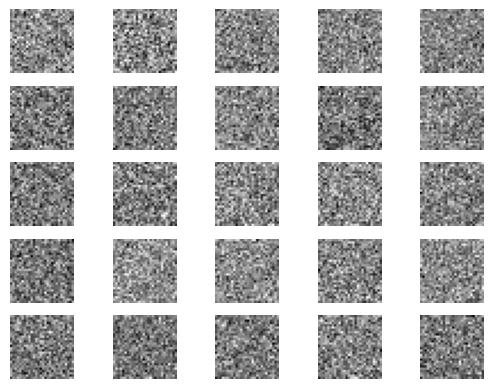

2/2 [==============================] - 0s 3ms/step


In [ ]:
# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the GAN
train(epochs=1000, batch_size=64, save_interval=1000)

# Question 01

## **Modify the latent space size (e.g., change the noise vector size from 100 to 50 or 200) and observe how this change affects the quality and variety of generated images.**

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_344 (Dense)           (None, 256)               13056     
                                                                 
 leaky_re_lu_246 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 batch_normalization_150 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dense_345 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_247 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                     

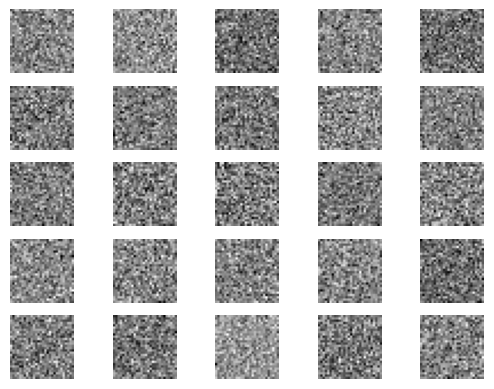

2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.3380354642868042, acc.: 85.15625%] [G loss: 3.340430974960327]
1/1 [==============================] - 0s 23ms/step


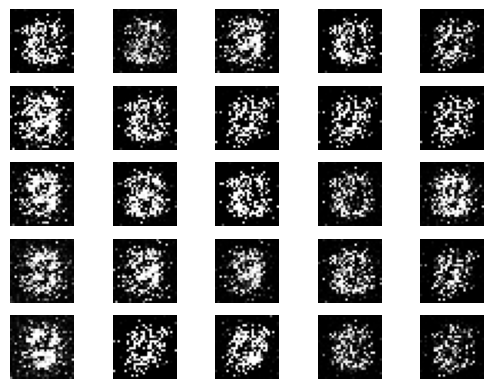

2/2 [==============================] - 0s 6ms/step
2000 [D loss: 0.1635815128684044, acc.: 94.53125%] [G loss: 4.030269622802734]
1/1 [==============================] - 0s 48ms/step


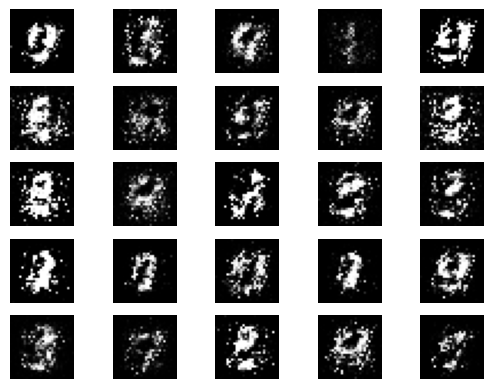

2/2 [==============================] - 0s 3ms/step
3000 [D loss: 0.5635545700788498, acc.: 70.3125%] [G loss: 2.5823686122894287]
1/1 [==============================] - 0s 19ms/step


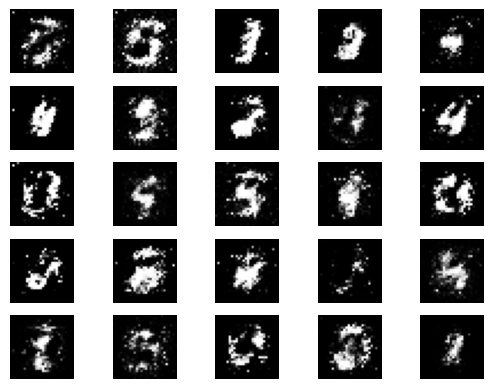

2/2 [==============================] - 0s 4ms/step
4000 [D loss: 0.5238527953624725, acc.: 75.78125%] [G loss: 1.7068569660186768]
1/1 [==============================] - 0s 21ms/step


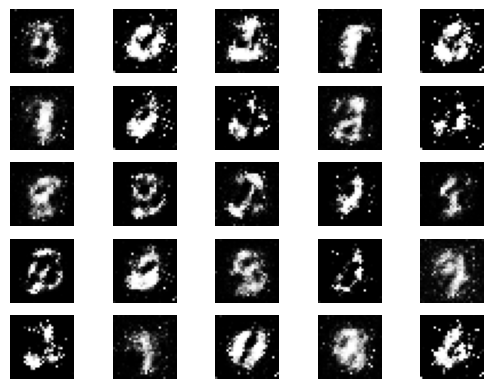

2/2 [==============================] - 0s 4ms/step
5000 [D loss: 0.6666131019592285, acc.: 57.03125%] [G loss: 1.4067411422729492]
1/1 [==============================] - 0s 23ms/step


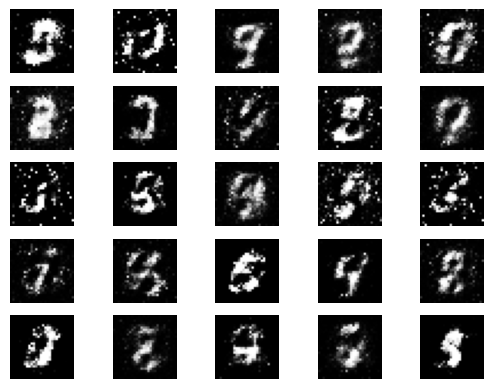

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Set latent space size (can change this to 50, 100, 200, etc.)
latent_dim = 50

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan

# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the GAN
train(epochs=5001, batch_size=64, save_interval=1000)


Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_358 (Dense)           (None, 256)               25856     
                                                                 
 leaky_re_lu_256 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 batch_normalization_156 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dense_359 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_257 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                    

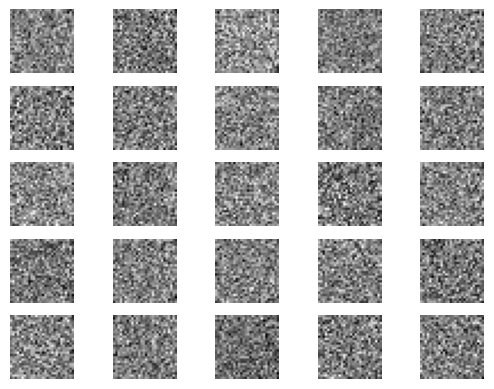

2/2 [==============================] - 0s 3ms/step
1000 [D loss: 0.3304259479045868, acc.: 85.9375%] [G loss: 4.161996841430664]
1/1 [==============================] - 0s 20ms/step


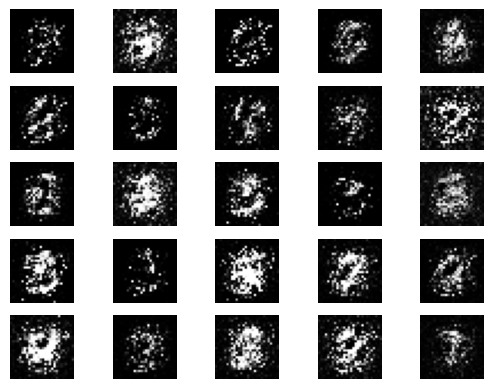

2/2 [==============================] - 0s 3ms/step
2000 [D loss: 0.4289919584989548, acc.: 80.46875%] [G loss: 2.2962751388549805]
1/1 [==============================] - 0s 19ms/step


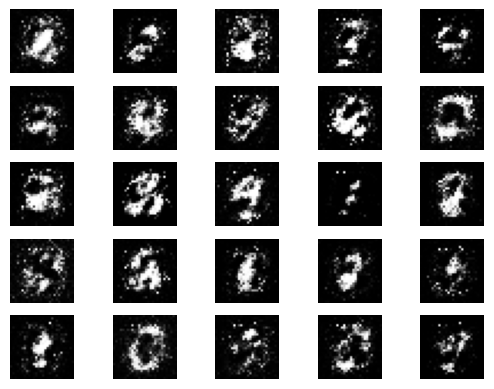

2/2 [==============================] - 0s 4ms/step
3000 [D loss: 0.6698637902736664, acc.: 61.71875%] [G loss: 1.2331345081329346]
1/1 [==============================] - 0s 29ms/step


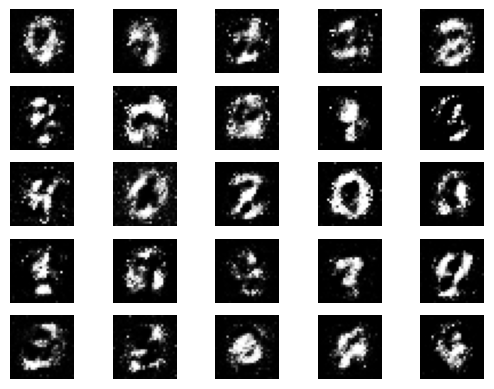

2/2 [==============================] - 0s 3ms/step
4000 [D loss: 0.7242324650287628, acc.: 59.375%] [G loss: 1.1127924919128418]
1/1 [==============================] - 0s 21ms/step


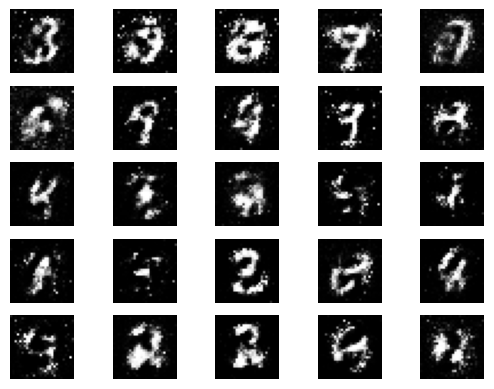

2/2 [==============================] - 0s 3ms/step
5000 [D loss: 0.46634382009506226, acc.: 78.125%] [G loss: 1.517412781715393]
1/1 [==============================] - 0s 21ms/step


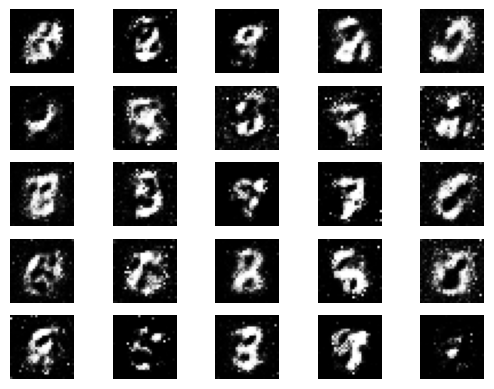

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Set latent space size (can change this to 50, 100, 200, etc.)
latent_dim = 100

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan

# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the GAN
train(epochs=5001, batch_size=64, save_interval=1000)


Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_372 (Dense)           (None, 256)               51456     
                                                                 
 leaky_re_lu_266 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 batch_normalization_162 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dense_373 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_267 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                    

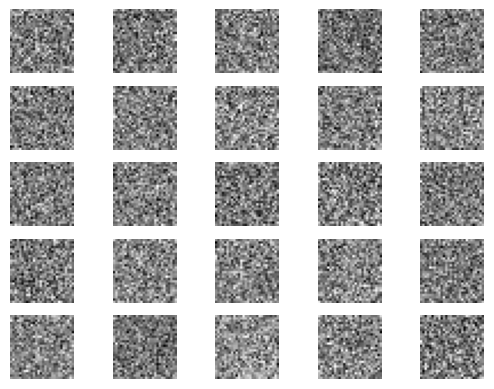

2/2 [==============================] - 0s 3ms/step
1000 [D loss: 0.19827218353748322, acc.: 91.40625%] [G loss: 3.691131114959717]
1/1 [==============================] - 0s 21ms/step


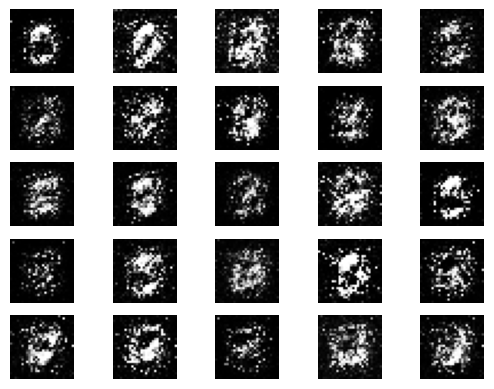

2/2 [==============================] - 0s 3ms/step
2000 [D loss: 0.7340185940265656, acc.: 65.625%] [G loss: 1.556889533996582]
1/1 [==============================] - 0s 21ms/step


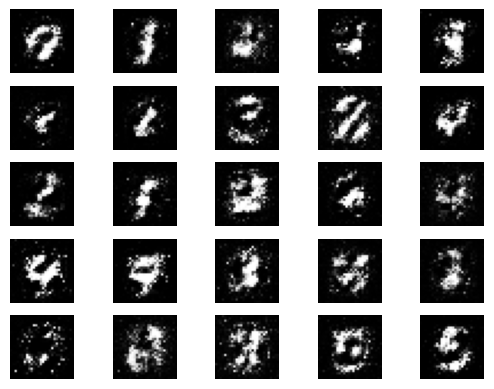

2/2 [==============================] - 0s 3ms/step
3000 [D loss: 0.7258903980255127, acc.: 52.34375%] [G loss: 0.8641648292541504]
1/1 [==============================] - 0s 22ms/step


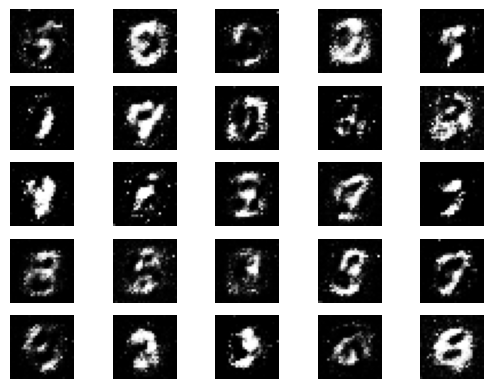

2/2 [==============================] - 0s 4ms/step
4000 [D loss: 0.48241642117500305, acc.: 78.125%] [G loss: 1.5083996057510376]
1/1 [==============================] - 0s 21ms/step


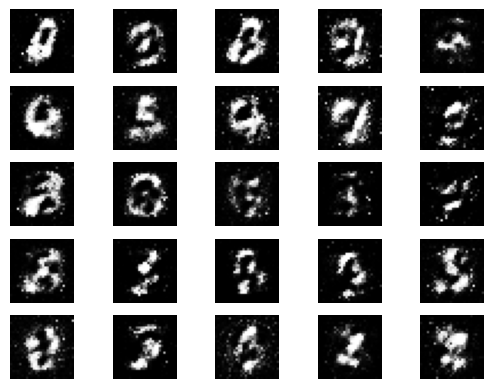

2/2 [==============================] - 0s 3ms/step
5000 [D loss: 0.44859395921230316, acc.: 82.03125%] [G loss: 1.513700008392334]
1/1 [==============================] - 0s 31ms/step


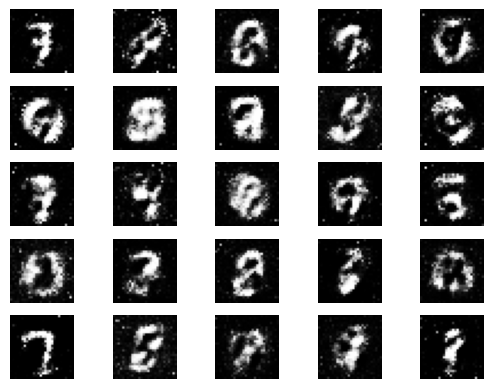

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Set latent space size (can change this to 50, 100, 200, etc.)
latent_dim = 200

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan

# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the GAN
train(epochs=5001, batch_size=64, save_interval=1000)


# Question 02

## **Train the GAN for 10,000 epochs. Save and visualize the generated images at every 1000 epochs, then create a GIF or a slideshow to show how the quality of the generated images evolves over time.**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Set latent space size and number of epochs
latent_dim = 100
epochs = 10000
save_interval = 1000

# Directory to save generated images
os.makedirs("gan_images", exist_ok=True)

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan

gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=1000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"gan_images/epoch_{epoch}.png")
    plt.close()

# Train the GAN
train(epochs=10000, batch_size=64, save_interval=1000)


2/2 [==============================] - 0s 4ms/step
0 [D loss: 0.7249865829944611, acc.: 54.6875%] [G loss: 0.6191409826278687]
2/2 [==============================] - 0s 2ms/step
1000 [D loss: 0.39903831481933594, acc.: 79.6875%] [G loss: 2.1769771575927734]
2/2 [==============================] - 0s 5ms/step
2000 [D loss: 0.6413472890853882, acc.: 60.9375%] [G loss: 1.5020867586135864]
2/2 [==============================] - 0s 3ms/step
3000 [D loss: 0.6154823303222656, acc.: 64.0625%] [G loss: 1.4241063594818115]
2/2 [==============================] - 0s 4ms/step
4000 [D loss: 0.6096102893352509, acc.: 65.625%] [G loss: 1.3478175401687622]
2/2 [==============================] - 0s 6ms/step
5000 [D loss: 0.5128909647464752, acc.: 73.4375%] [G loss: 1.2118232250213623]
2/2 [==============================] - 0s 8ms/step
6000 [D loss: 0.5241905450820923, acc.: 73.4375%] [G loss: 1.3778975009918213]
2/2 [==============================] - 0s 4ms/step
7000 [D loss: 0.5815533250570297, acc.: 71

In [ ]:
import imageio
import os

# Create a GIF from the saved images
def create_gif(output_path="gan_training_evolution.gif"):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"gan_images/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

# Generate the GIF
create_gif()
import imageio
import os

# Create a GIF from the saved images
def create_gif(output_path="gan_training_evolution.gif"):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"gan_images/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

# Generate the GIF
create_gif()


# Question 03

## **Change the optimizer from Adam to RMSprop or SGD for both the generator and discriminator, and observe the impact on training performance and image quality.**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import imageio
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD

# Set latent space size and number of epochs
latent_dim = 100
epochs = 1001
save_interval = 1000
batch_size = 64
optimizer_choice = 'rmsprop'  # Change this to 'adam', 'rmsprop', or 'sgd'

# Directory to save generated images
output_dir = f"gan_images_{optimizer_choice}"
os.makedirs(output_dir, exist_ok=True)

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()

# Choose optimizer based on the optimizer_choice variable
def get_optimizer(optimizer_choice):
    if optimizer_choice == 'adam':
        return Adam(0.0002)
    elif optimizer_choice == 'rmsprop':
        return RMSprop(learning_rate=0.0002)
    elif optimizer_choice == 'sgd':
        return SGD(learning_rate=0.01, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer choice. Use 'adam', 'rmsprop', or 'sgd'.")

# Compile GAN
def build_gan(generator, discriminator, optimizer_choice):
    optimizer = get_optimizer(optimizer_choice)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')
    return gan

# Build models and ensure optimizer is aware of the variables
discriminator_optimizer = get_optimizer(optimizer_choice)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

generator_optimizer = get_optimizer(optimizer_choice)
gan = build_gan(generator, discriminator, optimizer_choice)

# Ensure optimizer has the variables it needs by building models
discriminator.build(input_shape=(batch_size, 28, 28, 1))
generator.build(input_shape=(batch_size, latent_dim))
gan.build(input_shape=(batch_size, latent_dim))

# Training function
def train(epochs, batch_size, save_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

# Function to create GIF
def create_gif(output_path="gan_training_evolution.gif"):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"{output_dir}/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

# Train the GAN and create a GIF
train(epochs=epochs, batch_size=batch_size, save_interval=save_interval)
create_gif(f"gan_evolution_{optimizer_choice}.gif")


2/2 [==============================] - 0s 5ms/step
0 [D loss: 0.5614053308963776, acc.: 52.34375%] [G loss: 0.6416587829589844]
2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.6909817159175873, acc.: 50.0%] [G loss: 0.8052215576171875]
1/1 [==============================] - 0s 46ms/step


C:\Users\kavin\AppData\Local\Temp\ipykernel_14148\2561314816.py:134: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import imageio
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD

# Set latent space size and number of epochs
latent_dim = 100
epochs = 1001
save_interval = 1000
batch_size = 64
optimizer_choice = 'sgd'  # Change this to 'adam', 'rmsprop', or 'sgd'

# Directory to save generated images
output_dir = f"gan_images_{optimizer_choice}"
os.makedirs(output_dir, exist_ok=True)

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()

# Choose optimizer based on the optimizer_choice variable
def get_optimizer(optimizer_choice):
    if optimizer_choice == 'adam':
        return Adam(0.0002)
    elif optimizer_choice == 'rmsprop':
        return RMSprop(learning_rate=0.0002)
    elif optimizer_choice == 'sgd':
        return SGD(learning_rate=0.01, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer choice. Use 'adam', 'rmsprop', or 'sgd'.")

# Compile GAN
def build_gan(generator, discriminator, optimizer_choice):
    optimizer = get_optimizer(optimizer_choice)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')
    return gan

# Build models and ensure optimizer is aware of the variables
discriminator_optimizer = get_optimizer(optimizer_choice)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

generator_optimizer = get_optimizer(optimizer_choice)
gan = build_gan(generator, discriminator, optimizer_choice)

# Ensure optimizer has the variables it needs by building models
discriminator.build(input_shape=(batch_size, 28, 28, 1))
generator.build(input_shape=(batch_size, latent_dim))
gan.build(input_shape=(batch_size, latent_dim))

# Training function
def train(epochs, batch_size, save_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

# Function to create GIF
def create_gif(output_path="gan_training_evolution.gif"):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"{output_dir}/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

# Train the GAN and create a GIF
train(epochs=epochs, batch_size=batch_size, save_interval=save_interval)
create_gif(f"gan_evolution_{optimizer_choice}.gif")


2/2 [==============================] - 0s 7ms/step
0 [D loss: 0.8894298076629639, acc.: 8.59375%] [G loss: 0.6051123142242432]
2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.020973180886358023, acc.: 100.0%] [G loss: 5.2028374671936035]
1/1 [==============================] - 0s 64ms/step


C:\Users\kavin\AppData\Local\Temp\ipykernel_14148\1312064278.py:134: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import imageio
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD

# Set latent space size and number of epochs
latent_dim = 100
epochs = 1001
save_interval = 1000
batch_size = 64
optimizer_choice = 'adam'  # Change this to 'adam', 'rmsprop', or 'sgd'

# Directory to save generated images
output_dir = f"gan_images_{optimizer_choice}"
os.makedirs(output_dir, exist_ok=True)

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()

# Choose optimizer based on the optimizer_choice variable
def get_optimizer(optimizer_choice):
    if optimizer_choice == 'adam':
        return Adam(0.0002)
    elif optimizer_choice == 'rmsprop':
        return RMSprop(learning_rate=0.0002)
    elif optimizer_choice == 'sgd':
        return SGD(learning_rate=0.01, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer choice. Use 'adam', 'rmsprop', or 'sgd'.")

# Compile GAN
def build_gan(generator, discriminator, optimizer_choice):
    optimizer = get_optimizer(optimizer_choice)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')
    return gan

# Build models and ensure optimizer is aware of the variables
discriminator_optimizer = get_optimizer(optimizer_choice)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

generator_optimizer = get_optimizer(optimizer_choice)
gan = build_gan(generator, discriminator, optimizer_choice)

# Ensure optimizer has the variables it needs by building models
discriminator.build(input_shape=(batch_size, 28, 28, 1))
generator.build(input_shape=(batch_size, latent_dim))
gan.build(input_shape=(batch_size, latent_dim))

# Training function
def train(epochs, batch_size, save_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

# Function to create GIF
def create_gif(output_path="gan_training_evolution.gif"):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"{output_dir}/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_path, images, duration=1)

# Train the GAN and create a GIF
train(epochs=epochs, batch_size=batch_size, save_interval=save_interval)
create_gif(f"gan_evolution_{optimizer_choice}.gif")


2/2 [==============================] - 0s 15ms/step
0 [D loss: 0.6964917480945587, acc.: 39.84375%] [G loss: 0.5686236619949341]
2/2 [==============================] - 0s 4ms/step
1000 [D loss: 0.04090721346437931, acc.: 99.21875%] [G loss: 6.630617618560791]
1/1 [==============================] - 0s 56ms/step


C:\Users\kavin\AppData\Local\Temp\ipykernel_14148\387420260.py:134: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


# Question 04

## **Experiment with different values of the batch_size. What impact does it have on training?**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import imageio

# Set latent space size and number of epochs
latent_dim = 100
epochs = 1001
save_interval = 1000
batch_sizes = [16, 32, 64, 128]  # List of batch sizes to experiment with
optimizer_choice = 'adam'  # You can use 'adam', 'rmsprop', or 'sgd'

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Choose optimizer
def get_optimizer(optimizer_choice):
    if optimizer_choice == 'adam':
        return tf.keras.optimizers.legacy.Adam(0.0002)  # Use legacy Adam
    elif optimizer_choice == 'rmsprop':
        return tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0002)
    elif optimizer_choice == 'sgd':
        return tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer choice. Use 'adam', 'rmsprop', or 'sgd'.")

# Compile GAN
def build_gan(generator, discriminator, optimizer_choice):
    optimizer = get_optimizer(optimizer_choice)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False  # Ensure the discriminator is not trainable when training GAN
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')
    return gan

# Training function
def train(generator, discriminator, gan, batch_size, epochs, save_interval, output_dir):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"Batch size {batch_size}, Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(generator, epoch, batch_size, output_dir)

# Function to save generated images
def save_imgs(generator, epoch, batch_size, output_dir):
    noise = np.random.normal(0, 1, (25, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

# Function to create GIF
def create_gif(output_dir, batch_size):
    images = []
    for epoch in range(0, epochs + 1, save_interval):
        img_path = f"{output_dir}/epoch_{epoch}.png"
        if os.path.exists(img_path):
            images.append(imageio.imread(img_path))
    gif_path = f"{output_dir}/gan_evolution_batch_{batch_size}.gif"
    imageio.mimsave(gif_path, images, duration=1)
    print(f"GIF saved for batch size {batch_size}: {gif_path}")

# Loop through different batch sizes
for batch_size in batch_sizes:
    print(f"\n--- Training with batch size: {batch_size} ---")
    output_dir = f"gan_images_batch_{batch_size}"
    os.makedirs(output_dir, exist_ok=True)

    # Build models for each batch size experiment
    generator = build_generator()
    discriminator = build_discriminator()
    gan = build_gan(generator, discriminator, optimizer_choice)

    # Train the GAN
    train(generator, discriminator, gan, batch_size, epochs, save_interval, output_dir)

    # Create GIF for the current batch size
    create_gif(output_dir, batch_size)



--- Training with batch size: 16 ---
1/1 [==============================] - 0s 499ms/step
Batch size 16, Epoch 0 [D loss: 1.0056914985179901, acc.: 31.25%] [G loss: 0.7403993606567383]
1/1 [==============================] - 0s 77ms/step
Batch size 16, Epoch 1000 [D loss: 0.3823958486318588, acc.: 78.125%] [G loss: 3.751230239868164]
1/1 [==============================] - 0s 44ms/step


C:\Users\kavin\AppData\Local\Temp\ipykernel_14148\728685233.py:113: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


GIF saved for batch size 16: gan_images_batch_16/gan_evolution_batch_16.gif

--- Training with batch size: 32 ---
1/1 [==============================] - 0s 485ms/step
Batch size 32, Epoch 0 [D loss: 0.8187242746353149, acc.: 21.875%] [G loss: 0.7734439373016357]
1/1 [==============================] - 0s 91ms/step
Batch size 32, Epoch 1000 [D loss: 0.4494296610355377, acc.: 79.6875%] [G loss: 2.520435333251953]
1/1 [==============================] - 0s 57ms/step
GIF saved for batch size 32: gan_images_batch_32/gan_evolution_batch_32.gif

--- Training with batch size: 64 ---
2/2 [==============================] - 1s 14ms/step
Batch size 64, Epoch 0 [D loss: 0.6099421083927155, acc.: 60.15625%] [G loss: 0.6478145122528076]
2/2 [==============================] - 0s 4ms/step
Batch size 64, Epoch 1000 [D loss: 0.04046948440372944, acc.: 99.21875%] [G loss: 8.640414237976074]
1/1 [==============================] - 0s 36ms/step
GIF saved for batch size 64: gan_images_batch_64/gan_evolution_bat